In [20]:
import sys
sys.path.append('../')

import torch
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryAUROC, BinaryConfusionMatrix, BinaryPrecision, BinaryRecall
from tqdm import tqdm
import wandb
import numpy as np
import sys
from src.data.ImageClassificationDataset import ImageClassificationDataset
from src.data.ImageDataset import ImageDataset
from src.models.model import SimpleCNN, XrayCNN, XrayCNN_mini
from torchvision.transforms import transforms
import os
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from src.data.preprocessing import EqualizeClahe
from torchsummary import summary
import torchvision

# Model

In [23]:
MODEL_NAME = "model1.pth"
# MODEL_NAME = "model2.pth"
# MODEL_NAME = "model3.pth"
# MODEL_NAME = "model4_model1_with_DA.pth"

model_path = f"../models/{MODEL_NAME}"

if "model1" in model_path:
    model = SimpleCNN()
elif "model2" in model_path:
    model = XrayCNN()
elif "model3" in model_path:
    model = XrayCNN_mini()
else:
    raise NotImplementedError()

model.load_state_dict(torch.load(model_path))

summary(model.cuda(), (3, 256, 256))

model.cpu()
model.eval()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 252, 252]             456
         MaxPool2d-2          [-1, 6, 126, 126]               0
            Conv2d-3         [-1, 16, 122, 122]           2,416
         MaxPool2d-4           [-1, 16, 61, 61]               0
            Linear-5                  [-1, 120]       7,144,440
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 2]             170
Total params: 7,157,646
Trainable params: 7,157,646
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 5.91
Params size (MB): 27.30
Estimated Total Size (MB): 33.96
----------------------------------------------------------------


SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

# Data

In [17]:
def imshow(img):
    print(type(img))
    img = img / 2 + 0.5 #if denormalization is needed
    npimg = np.array(img)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [27]:
DATA_ROOT = "../data/processed/raw_corrected"
TEST_BATCH_SIZE = 8

test_root = os.path.join(DATA_ROOT, "Test")

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

test_dataset = ImageClassificationDataset(test_root, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = TEST_BATCH_SIZE, shuffle = True)

In [28]:
ind_to_class = test_dataset.ind_to_class
ind_to_class

{0: 'Lateral', 1: 'AP'}

8
<class 'torch.Tensor'>


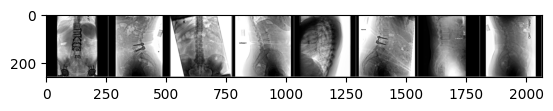

Ground Truth:  AP Lateral AP Lateral Lateral Lateral Lateral Lateral


In [33]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
labels = labels.tolist()
print(len(labels))

imshow(torchvision.utils.make_grid(images))
print("Ground Truth: ", " ".join(f'{ind_to_class[labels[j]]}' for j in range(TEST_BATCH_SIZE)))

# Predict

In [34]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)
predicted = predicted.tolist()

print("Predictions: ", " ".join(f'{ind_to_class[predicted[j]]}' for j in range(TEST_BATCH_SIZE)))

Predictions:  AP Lateral AP AP Lateral AP Lateral Lateral
